In [9]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pdpbox import pdp, info_plots
from category_encoders import OneHotEncoder
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from utils import get_val_scores



In [10]:
df = pd.read_csv('../data/insurance_premiums.csv')

In [11]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [12]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Initial Observations and Predictions

Beginning with summary statistics, there is already a lot I can tell about the customers from insurance dataset. The customers range in age from 18-64, with a mean age of 39. Premium changes range from \\$1,100 to nearly \\$64,000. 
<br>
<br>
The first big question I have is whether the charges paid will simply track with the customers age. I don't have access to information how long customers paid premiums for, but it seems reasonable that on average, people who are older will have paid more over their lifetime.
<br>
<br>
I would expect BMI and smoking to track with higher charges, because insurance companies probably assume that customers with these characteristics would have more chronic health issues on average and would therefore be more risky to cover. [Smoking](https://www.cdc.gov/chronicdisease/resources/publications/factsheets/tobacco.htm) in particular is considered to be a major risk factor for a number of chronic conditions, like heart disease, cancer, and stroke.
<br>
<br>
I think the children column could be interesting as well. It could be that having children, as a female, impacts health outcomes more than males having children (due to pregnancy or other complications). It's unclear whether the children are also insured and if that premium would be included in charges. If the premiums paid for children were factored into the charges, however, I would expect them to be a bigger factor for younger people than for older people--older customers who have adult children over the age of 26 would not likely be paying insurance premiums for their adult children. Under the [Affordable Care Act (ACA)](https://www.dol.gov/agencies/ebsa/about-ebsa/our-activities/resource-center/faqs/young-adult-and-aca), insurers are required to offer coverage to dependents up to age 26.

To confirm or refute some of my initial predictions, I can plot by various categories and look at the resulting boxplot to get a rough idea of factors that could be impactful:

In [42]:
fig1 = px.box(df, x="sex", y="charges", title="Charges for Smokers by Sex", 
              color="smoker", labels={'charges':'Charges',
                                      'sex':'Sex', 'smoker':'Smoker'})

fig1.show()

I can see from the above boxplot that sex doesn't seem to have a significant impact on what people pay on average. Smoking, however, *significantly* increases both the average charges and the variance of charges within each group.

In [14]:
fig2 = px.box(df, x="region", y="charges", title="Charges for Customers by Region",
              labels={'charges':'Charges', 'region':'Region'})

fig2.show()

The region a customer lives in doesn't seem to significantly impact the amount they pay.

In [43]:
fig3 = px.histogram(df, x='bmi', y='charges', histfunc='avg',
                   title="Average Charges by BMI",
                   labels={'bmi':'BMI', 'avg of charges':'Average Charges'})

fig3.show()

BMI data is a bit more messy, although there seems to be an upward trend for charges as BMI increases, especially past 35 or so. 
<br>
<br>
Binning the BMI values into useful chunks may provide more insight. According to the [CDC](https://www.cdc.gov/obesity/adult/defining.html), BMI can be classified in the following way:
<br>
<br>
<br>

| BMI Range | Classification   |
|------|------|
|   < 18.5  | Underweight|
|   18.5 - 25  | Normal|
|   25 - 30 | Overweight|
|   30 - 35  | Obese Class 1|
|   35 - 40  | Obese Class 2|
|   > 40  | Obese Class 3|

<br>
<br>
If I start at BMI 15 and use bin width 5, I can quickly and conveniently split the histogram into chunks that reasonably correspond with BMI classifications.

In [16]:
fig4 = go.Figure()
fig4.add_trace(go.Histogram(
    x=df['bmi'],
    y=df['charges'],
    histnorm='',
    histfunc='avg',
    xbins=dict(start=15,
               end=55,
               size=5),
    autobinx=False))

fig4.update_layout(
    title_text='Average Charges by BMI', # title of plot
    xaxis_title_text='BMI', # xaxis label
    yaxis_title_text='Average Charge', # yaxis label
)
fig4.show()

Given that the overall mean charge for the entire dataset is around $13k, I can see that BMI of 30 seems to be the point where people start paying more, on average, for insurance premiums. This corresponds to **Obesity, Class 1** BMI classification.

### Data Prep and Cleanup

In [17]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Fortunately, this dataset doesn't have any missing values.
<br>
<br>
However, much of the data is categorical in nature, so I will want to encode it somehow. Given how few distinct values are in several of the categorical columns (specifically, sex, smoker, and region), I would like to use **One Hot Encoding** because it will lend a high degree of granularity without adding too many columns. 

### Initial Modeling and Validation

I'll first do a round of gradient boosting with default settings:

In [18]:
ohe = OneHotEncoder(use_cat_names=True)
X = df.drop(['charges'], axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1985)
# because 1985 is best year.

X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)


In [19]:
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
gbm.score(X_train, y_train), gbm.score(X_test, y_test)

(0.8993544535956044, 0.8714543078908485)

This validation score is rather high, which may suggest some over-fitting. However, it does score almost as well on the test data set, so it could just be that the dataset has high predictability.

In [20]:
feats = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gbm.feature_importances_
}).sort_values(by='Importance', ascending=False)
feats

,Feature,Importance
5,smoker_no,0.393041
6,smoker_yes,0.287068
3,bmi,0.187731
0,age,0.114458
4,children,0.013221
9,region_northeast,0.001588
2,sex_male,0.001101
8,region_southeast,0.000732
7,region_southwest,0.000558
10,region_northwest,0.000281


It's not surprising that smoking factors heavily into charges, but thanks to One Hot Encoding, I can see that **not** smoking specifically has much higher importance in the model. BMI plays an important role, but less so than smoking/not smoking. Age is the final criterion that has any major predictive power. After that, the other features barely make an impact.
<br>
<br>

Graphing the impact of smoking yields similar insights gained from my boxplots above; namely, smokers are predicted to pay significantly higher charges:

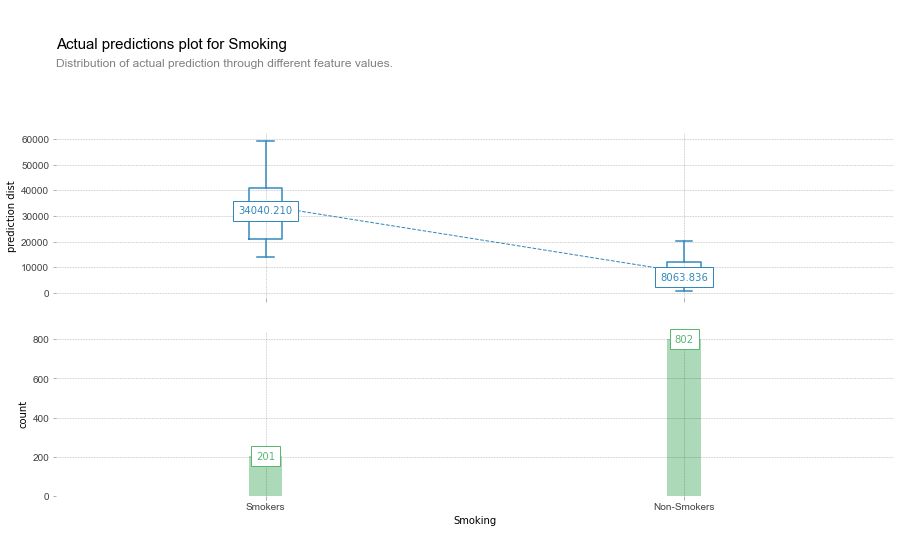

In [21]:
fig, axes, summary_df = info_plots.actual_plot(
    model = gbm, X=X_train, 
    feature='smoker_no', feature_name='Smoking', predict_kwds={}
)
axes['bar_ax'].set_xticklabels(['Smokers','Non-Smokers']);

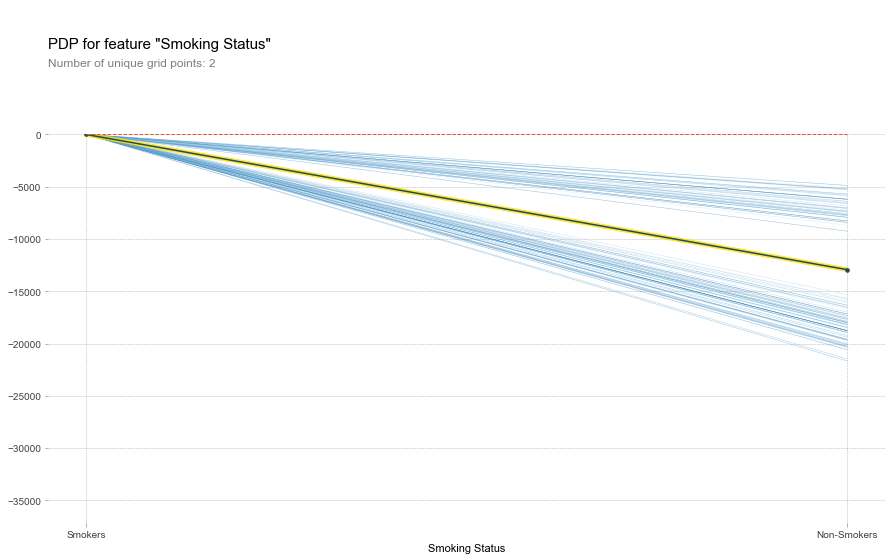

In [22]:
pdp_smoking = pdp.pdp_isolate(
    model = gbm, dataset = X_train, model_features = X_train.columns.tolist(), 
    feature='smoker_no', cust_grid_points = X_train['smoker_no'].tolist()
)

fig, axes = pdp.pdp_plot(pdp_smoking, 'Smoking Status', plot_lines=True, frac_to_plot=100)
axes['pdp_ax'].set_xticklabels(['Smokers','Non-Smokers']);

I would like to tweak my model a bit before moving on to feature engineering. I will try different tree depths and numbers of trees:

In [23]:
# Tree depths:
for depth in range(3,7):
    print(f"Fitting model for max_depth of {depth}")
    gbm = GradientBoostingRegressor(max_depth=depth)
    gbm.fit(X_train, y_train)
    print(f"Out of sample score:  {gbm.score(X_test, y_test)}")

Fitting model for max_depth of 3
Out of sample score:  0.8716396936226943
Fitting model for max_depth of 4
Out of sample score:  0.8634973648500321
Fitting model for max_depth of 5
Out of sample score:  0.8540769216031474
Fitting model for max_depth of 6
Out of sample score:  0.8418876889920198


Unsurprisingly, the scores dip dramatically the more splits occur. This makes sense given the small number of columns in this dataset and the fact that only about 4 of them provide significant predictive ability.
<br>
<br>
**The best depth to use is 3**.

In [24]:
for num_tree in range(50,550,50):
    print(f"Fitting model for {num_tree} estimators")
    gbm = GradientBoostingRegressor(n_estimators=num_tree)
    gbm.fit(X_train, y_train)
    print(f"Out of sample score:  {gbm.score(X_test, y_test)}")

Fitting model for 50 estimators
Out of sample score:  0.8743078764083684
Fitting model for 100 estimators
Out of sample score:  0.871473698024949
Fitting model for 150 estimators
Out of sample score:  0.8651278849895154
Fitting model for 200 estimators
Out of sample score:  0.8617669632709988
Fitting model for 250 estimators
Out of sample score:  0.8571528691563424
Fitting model for 300 estimators
Out of sample score:  0.8529687586319703
Fitting model for 350 estimators
Out of sample score:  0.8508369715859022
Fitting model for 400 estimators
Out of sample score:  0.84558987027671
Fitting model for 450 estimators
Out of sample score:  0.845366822964632
Fitting model for 500 estimators
Out of sample score:  0.8444410362499069


The dataset is small, and it turns out running 50 trees results in a model just as good as running 100 trees. This means that we can cut the model fitting run time in half and get equally good results! 
<br>
<br>
**The best number of trees to use is 50**.

In [25]:
#running the model again, but with improved model parameters based on what I learned above:
gbm = GradientBoostingRegressor(n_estimators=50,max_depth=3)
gbm.fit(X_train, y_train)
gbm.score(X_train, y_train), gbm.score(X_test, y_test)

(0.8823360126567287, 0.8743078764083684)

Great! This model is less over-fit to my training data, and I saw a tiny increase in performance on the test set as well.

### Feature Engineering

Based on my previous observations of the data as well as my intuition, I would like to make the following transformations to the dataset to see if I can improve the predictions from the model:
* Classify BMI (underweight, obese, etc.)
* Find interactions between smoking and obesity

#### Classify BMI

In [26]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [27]:
bmis = [df['bmi'] < 18.5,
        df['bmi'].between(18.5, 25),
        df['bmi'].between(25, 30),
        df['bmi'].between(30, 35),
        df['bmi'].between(35, 40),
        df['bmi'] >= 40]

bmi_classes = ['underweight', 'normal', 'overweight', 'obese1', 'obese2', 'obese3']

df['bmi_class'] = np.select(bmis, bmi_classes)


In [28]:
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_class
0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,18,male,33.770,1,no,southeast,1725.55230,obese1
2,28,male,33.000,3,no,southeast,4449.46200,obese1
3,33,male,22.705,0,no,northwest,21984.47061,normal
4,32,male,28.880,0,no,northwest,3866.85520,overweight


In [29]:
fig5 = px.histogram(df, x='bmi_class', y='charges', histfunc='avg',
                    title="Average Charge by BMI Classification",
                   labels={'bmi_class':'BMI Classification', 'avg of charges':'Average Charges'})


fig5.show()

This visualization makes it much clearer how obese customers paid significantly more than average. 

In [30]:
ohe = OneHotEncoder(use_cat_names=True)
#dropping BMI because it's being captured as a bmi class
X = df.drop(['charges', 'bmi'], axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1985)


X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [31]:
gbm = GradientBoostingRegressor(n_estimators=50,max_depth=3)
gbm.fit(X_train, y_train)
gbm.score(X_train, y_train), gbm.score(X_test, y_test)

(0.8755603255625591, 0.8745587010108857)

In [32]:
feats = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gbm.feature_importances_
}).sort_values(by='Importance', ascending=False)
feats

,Feature,Importance
5,smoker_yes,0.550194
4,smoker_no,0.148915
0,age,0.119078
10,bmi_class_normal,0.083457
14,bmi_class_overweight,0.061771
3,children,0.012184
12,bmi_class_obese2,0.009480
11,bmi_class_obese3,0.006068
15,bmi_class_underweight,0.004971
8,region_northeast,0.001341


Adding the BMI Classification feature seemed to modestly improve the over-fitting of the previous model and added a tiny bit more predictive power in predicting the test dataset charges. Counterintuitively, the Normal and Overweight classes were more predictive than the Obese.

#### Link Smoking and BMI

In [33]:
# not the most efficient way to do this; future work will do this programatically:
conditions = [(df['bmi_class'] == 'underweight') & 
              (df['smoker'] == 'yes'),
              (df['bmi_class'] == 'underweight') & 
              (df['smoker'] == 'no'),
              (df['bmi_class'] == 'normal') & 
              (df['smoker'] == 'yes'),
              (df['bmi_class'] == 'normal') & 
              (df['smoker'] == 'no'),
              (df['bmi_class'] == 'overweight') & 
              (df['smoker'] == 'yes'),
              (df['bmi_class'] == 'overweight') & 
              (df['smoker'] == 'no'),
              (df['bmi_class'] == 'obese1') & 
              (df['smoker'] == 'yes'),
              (df['bmi_class'] == 'obese1') & 
              (df['smoker'] == 'no'),
              (df['bmi_class'] == 'obese2') & 
              (df['smoker'] == 'yes'),
              (df['bmi_class'] == 'obese2') & 
              (df['smoker'] == 'no'),
              (df['bmi_class'] == 'obese3') & 
              (df['smoker'] == 'yes'),
              (df['bmi_class'] == 'obese3') & 
              (df['smoker'] == 'no'),
             ]
              

smoker_bmi_class = ['underweight smoker', 'underweight non-smoker',
                   'normal smoker', 'normal non-smoker',
                   'overweight smoker', 'overweight non-smoker',
                   'obese1 smoker', 'obese1 non-smoker',
                   'obese2 smoker', 'obese2 non-smoker',
                   'obese3 smoker', 'obese3 non-smoker',]

df['smoker_bmi'] = np.select(conditions, smoker_bmi_class)

In [34]:
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_class,smoker_bmi
0,19,female,27.900,0,yes,southwest,16884.92400,overweight,overweight smoker
1,18,male,33.770,1,no,southeast,1725.55230,obese1,obese1 non-smoker
2,28,male,33.000,3,no,southeast,4449.46200,obese1,obese1 non-smoker
3,33,male,22.705,0,no,northwest,21984.47061,normal,normal non-smoker
4,32,male,28.880,0,no,northwest,3866.85520,overweight,overweight non-smoker


Finally, let's see if this feature adds any additional power:

In [35]:
ohe = OneHotEncoder(use_cat_names=True)
#dropping BMI because it's being captured as a bmi class
X = df.drop(['charges', 'bmi'], axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1985)


X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [36]:
gbm = GradientBoostingRegressor(n_estimators=50,max_depth=3)
gbm.fit(X_train, y_train)
gbm.score(X_train, y_train), gbm.score(X_test, y_test)

(0.8768774580072557, 0.8767303772702244)

In [37]:
feats = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gbm.feature_importances_
}).sort_values(by='Importance', ascending=False)
feats

,Feature,Importance
4,smoker_no,0.362095
5,smoker_yes,0.331575
0,age,0.119306
10,bmi_class_normal,0.041875
24,smoker_bmi_normal smoker,0.038538
23,smoker_bmi_overweight smoker,0.037396
14,bmi_class_overweight,0.022415
22,smoker_bmi_obese2 smoker,0.011561
3,children,0.010770
25,smoker_bmi_obese3 smoker,0.007361


One interesting thing I noted is that being a smoker with normal BMI has more impact on the charges than being overweight in general. While this is the best version of the model/dataset yet, the gains have been extremely modest. That could be because smokers are a relatively small subset of the group, and once we begin breaking down the dataset by smoking AND BMI, the number of people in each category shrinks accordingly:

In [38]:
df.groupby('smoker_bmi').size()

smoker_bmi
normal non-smoker         177
normal smoker              50
obese1 non-smoker         316
obese1 smoker              73
obese2 non-smoker         175
obese2 smoker              50
obese3 non-smoker          70
obese3 smoker              21
overweight non-smoker     311
overweight smoker          75
underweight non-smoker     15
underweight smoker          5
dtype: int64

In [39]:
df['Predicted Charges'] = gbm.predict(ohe.transform(X))

In [40]:
df.head()

,age,sex,bmi,children,smoker,region,charges,bmi_class,smoker_bmi,Predicted Charges
0,19,female,27.900,0,yes,southwest,16884.92400,overweight,overweight smoker,18482.303535
1,18,male,33.770,1,no,southeast,1725.55230,obese1,obese1 non-smoker,4183.790857
2,28,male,33.000,3,no,southeast,4449.46200,obese1,obese1 non-smoker,6862.398801
3,33,male,22.705,0,no,northwest,21984.47061,normal,normal non-smoker,4391.322872
4,32,male,28.880,0,no,northwest,3866.85520,overweight,overweight non-smoker,4391.322872


In [41]:
fig6 = px.scatter(df, x='charges', y='Predicted Charges', title='Actual vs. Predicted Charges',
                 trendline='ols',
                 labels={'charges':'Charges'})
fig6.show()

If I could do this project again, I would want to make use of more powerful gradient boosting tools, like XGBoost and use k-folds for validation. For homework 4, I want to vastly improve my familiarity with these methods and do deeper analyses on more complex datasets.